In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'using device {device}')

using device cuda


In [3]:
def plot_activation_function(function: callable, name: str) -> None:
    ''' Plots the activation function for a given function and name.
    Args:
        function: The activation function to plot.
        name: The name of the activation function.

    Returns:
        None    
    '''

    x = torch.linspace(-10, 10, 1000)
    y = function(x)
    plt.plot(x, y)
    plt.title(f'Activation function: {name}')
    plt.xlabel('Input')
    plt.ylabel('Response')
    plt.grid()
    plt.show()

In [4]:
def spike_function(x: torch.Tensor) -> torch.Tensor:
    """Computes the spike function for a given input.
    Args:
        x: The input tensor.

    Returns:
        The spike function.
    """
    return x > 0

In [5]:
class LIF(torch.nn.Module):
    """A spiking neuron based on the leaky integrate-and-fire model."""
    def __init__(
        self,
        tau_mem: float = 20e-3,
        tau_syn: float = 5e-3,
        threshold: float = 1.0,
        v_rest: float = 0.0,
        v_reset: float = 0.0,
        dt: float = 1e-3,
        spike_fn: callable = spike_function,
    ) -> None:
        super().__init__()
        self.tau_mem = tau_mem
        self.tau_syn = tau_syn
        self.threshold = threshold
        self.v_rest = v_rest
        self.v_reset = v_reset
        self.dt = torch.tensor(dt)
        self.spike_fn = spike_fn

        self.alpha = torch.exp(-self.dt / self.tau_syn)
        self.beta = torch.exp(-self.dt / self.tau_mem)

        self.reset()

    def reset(self) -> None:
        """Resets the membrane potential to the resting potential.
        Args:
            None

        Returns:
            None
        """
        self.i_syn = torch.tensor(0.0)
        self.v_mem = torch.tensor(self.v_rest)

    def forward(self, i_in: torch.Tensor) -> torch.Tensor:
        """Performs a forward pass through the LIF neuron.
        Args:
            i_syn: The synaptic input current.

        Returns:
            output activity of the LIF neuron.
        """

        # integrate synaptic current
        self.i_syn = self.alpha * self.i_syn + i_in
        # update membrane potential
        self.v_mem = self.beta * self.v_mem + (1 - self.beta) * self.i_syn
        # generate output spike
        spike = self.spike_fn(self.v_mem - self.threshold)
        # reset membrane potential
        self.v_mem = torch.where(spike, self.v_reset, self.v_mem)

        return spike

In [6]:
# some hyperparameters
T = 0.6 # total time to simulate (s)
dt = 1e-3 # simulation time step (s)
time = torch.arange(0, T+dt, dt) # time array

In [7]:
# LIF parameters
v_rest = 0.0 # resting potential (mV)
v_reset = 0.0 # reset potential (mV)
tau_mem = 50e-3 # membrane time constant (s)
tau_syn = 20e-3 # synaptic time constant (s)
threshold = 1.0 # spike threshold (V)

In [8]:
# create input spike train
input = torch.zeros(time.shape)
input[100:200] = 0.06
input[400:500] = 0.5

In [9]:
# create LIF neuron
lif = LIF(
    tau_mem=tau_mem,
    tau_syn=tau_syn,
    threshold=threshold,
    v_rest=v_rest,
    v_reset=v_reset,
    dt=dt,
)

In [10]:
# simulate LIF neuron
spike_train = []
currents = []
voltages = []
for i in range(len(time)):
    # get current input
    i_in = input[i]
    # perform forward pass through LIF neuron
    spike = lif(i_in)
    # store spike
    spike_train.append(spike)
    # store current
    currents.append(lif.i_syn)
    # store voltage
    voltages.append(lif.v_mem)

In [11]:
# convert lists to tensors
spike_train = torch.stack(spike_train)
currents = torch.stack(currents)
voltages = torch.stack(voltages)

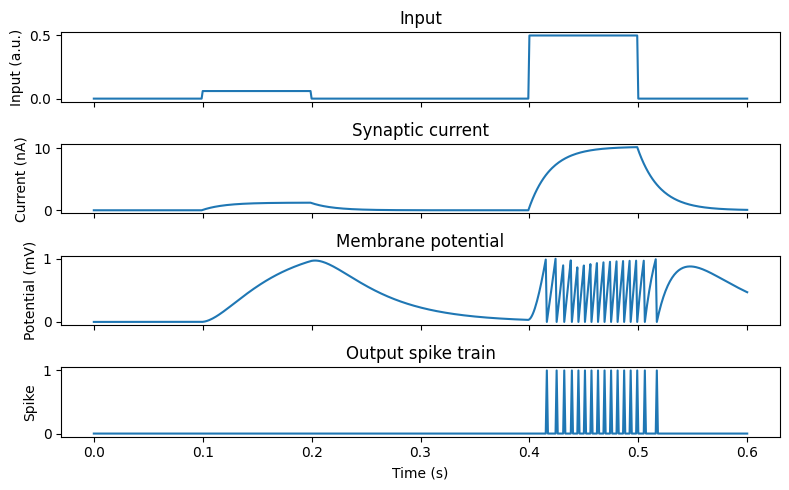

In [12]:

# plot input spike train
fig, axs = plt.subplots(4, 1, figsize=(8, 5))
axs[0].set_title('Input')
axs[0].set_ylabel('Input (a.u.)')
axs[0].plot(time, input)
axs[0].tick_params(axis='x', which='both', bottom=True, labelbottom=False)

# plot synaptic current
axs[1].set_title('Synaptic current')
axs[1].set_ylabel('Current (nA)')
axs[1].plot(time, currents)
axs[1].tick_params(axis='x', which='both', bottom=True, labelbottom=False)

# plot membrane potential
axs[2].set_title('Membrane potential')
axs[2].set_ylabel('Potential (mV)')
axs[2].plot(time, voltages)
axs[2].tick_params(axis='x', which='both', bottom=True, labelbottom=False)

# plot output spike train
axs[3].set_title('Output spike train')
axs[3].set_xlabel('Time (s)')
axs[3].set_ylabel('Spike')
axs[3].plot(time, spike_train)

plt.tight_layout()
plt.show()

